In [2]:
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy import special
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
data2014 = pd.read_csv("Our_Dataset/2014dataset.csv")
data2015 = pd.read_csv("Our_Dataset/2015dataset.csv")
data2016 = pd.read_csv("Our_Dataset/2016dataset.csv")
data2017 = pd.read_csv("Our_Dataset/2017dataset.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,52,323,649,882,932,1092,1202) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,57,204,341,376,377,396,430,431,928,944,1006,1013,1151,1160,1169,1179,1411) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,17,163,355,406,702,835,847,1083,1156,1183,1185,1200) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Create the labels.
# By index:
# label 2 is transfers
# label 3 is premiums
# label 4 is costs
# label 5 is member months
# label 6 is reinsurance (individual group only)

ind_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                  "HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)",
                  "1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "STATE", "REINSURANCE PAYMENT AMOUNT (OR NOT ELIGIBLE)"] # no more reinsurance as of 2017
ind_labels_15 = [label.replace('15', '16') for label in ind_labels_14]
ind_labels_16 = [label.replace('15', '17') for label in ind_labels_14]
ind_labels_17 = [label.replace('15', '18') for label in ind_labels_14][:-1]

sg_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                 "HHS RISK ADJUSTMENT TRANSFERS AMOUNT (SMALL GROUP MARKET)",
                  "1.1Directpremiumwritten7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "2.16Totalincurredclaims7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "7.4Membermonths7HealthInsuranceSMALLGROUPTotalasof3/31/15", "STATE"]
sg_labels_15 = [label.replace('15', '16') for label in sg_labels_14]
sg_labels_16 = [label.replace('15', '17') for label in sg_labels_14]
sg_labels_17 = [label.replace('15', '18') for label in sg_labels_14]

In [5]:
# Filter the data to include only the fields we want

ind_data_14 = data2014[ind_labels_14].dropna()
ind_data_15 = data2015[ind_labels_15].dropna()
ind_data_16 = data2016[ind_labels_16].dropna()
ind_data_17 = data2017[ind_labels_17].dropna()
sg_data_14 = data2014[sg_labels_14].dropna()
sg_data_15 = data2015[sg_labels_15].dropna()
sg_data_16 = data2016[sg_labels_16].dropna()
sg_data_17 = data2017[sg_labels_17].dropna()

In [6]:
# Drop companies with <2000 MM
ind_data_14 = ind_data_14.where(ind_data_14[ind_labels_14[5]] > 2000).dropna()
ind_data_15 = ind_data_15.where(ind_data_15[ind_labels_15[5]] > 2000).dropna()
ind_data_16 = ind_data_16.where(ind_data_16[ind_labels_16[5]] > 2000).dropna()
ind_data_17 = ind_data_17.where(ind_data_17[ind_labels_17[5]] > 2000).dropna()
sg_data_14 = sg_data_14.where(sg_data_14[sg_labels_14[5]] > 2000).dropna()
sg_data_15 = sg_data_15.where(sg_data_15[sg_labels_15[5]] > 2000).dropna()
sg_data_16 = sg_data_16.where(sg_data_16[sg_labels_16[5]] > 2000).dropna()
sg_data_17 = sg_data_17.where(sg_data_17[sg_labels_17[5]] > 2000).dropna()

In [7]:
# Calculate transfers, premiums, costs, and reinsurance (if individual group) per member month
def calculate_pmm(df, df_labels, group):
    df["MM"] = df[df_labels[5]]
    df["Transfers"] = df[df_labels[2]]
    df["Enrollees"] = df["MM"] / 12
    df["TransfersPerEnrollee"] = df["Transfers"] / df["Enrollees"]
    df["TransfersPerSqrtEnrollee"] = df["Transfers"] / np.sqrt(df["Enrollees"])
    df["LogEnrollees"] = np.log(df["Enrollees"])
    df["LogTransfers"] = np.log(df["Transfers"]**2 + 1)
    df["TransfersPMM"] = df[df_labels[2]] / df[df_labels[5]]
    df["PremiumsPMM"] = abs(df[df_labels[3]] / df[df_labels[5]])
    df["CostsPMM"] = abs(df[df_labels[4]] / df[df_labels[5]])
    if group == "i":
        df["ReinsurancePMM"] = df[df_labels[7]] / df[df_labels[5]]
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"] + df["ReinsurancePMM"]
        #df["PremMinusCostsPlusReinsurancePMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["ReinsurancePMM"]
    elif group == "sg":
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["PremMinusCostsPMM"] = df["PremiumsPMM"] - df["CostsPMM"]
    df["PremMinusCostsPlusTransfersPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["SicknessPMM"] = df["CostsPMM"] - df["PremiumsPMM"]
    average_sickness = np.mean(df["SicknessPMM"])
    df["ExcessSicknessPMM"] = df["SicknessPMM"] - average_sickness
    return df

ind_data_14 = calculate_pmm(ind_data_14, ind_labels_14, "i")
ind_data_15 = calculate_pmm(ind_data_15, ind_labels_15, "i")
ind_data_16 = calculate_pmm(ind_data_16, ind_labels_16, "i")
ind_data_17 = calculate_pmm(ind_data_17, ind_labels_17, "sg")
sg_data_14 = calculate_pmm(sg_data_14, sg_labels_14, "sg")
sg_data_15 = calculate_pmm(sg_data_15, sg_labels_15, "sg")
sg_data_16 = calculate_pmm(sg_data_16, sg_labels_16, "sg")
sg_data_17 = calculate_pmm(sg_data_17, sg_labels_17, "sg")

In [8]:
# Combine the dataframes by left merging

ind_data = ind_data_14.merge(ind_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(ind_data_16, on='HIOS ID', how='outer').merge(ind_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [9]:
# Do the same thing for small group

sg_data = sg_data_14.merge(sg_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(sg_data_16, on='HIOS ID', how='outer').merge(sg_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [10]:
sg_data.shape

(611, 85)

In [11]:
def plot(df, label, show_graphs):
    no_nulls = df[['LogEnrollees', 'LogTransfers']].dropna()
    X = no_nulls[['LogEnrollees']]
    y = no_nulls['LogTransfers']
    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()
    equation = "Log T = %f + %f * Log Enrollees" % (est.params[0], est.params[1])
    if show_graphs:
        fig, ax = plt.subplots(figsize=(8,8))
        plt.scatter(df["LogEnrollees"], df["LogTransfers"])
        x = np.linspace(min(df["LogEnrollees"]), max(df["LogEnrollees"]), 1000)
        plt.plot(x, est.params[0] + est.params[1] * x, label=equation)
        plt.title(label)
        plt.xlabel("Log # Enrollees")
        plt.ylabel("Log Transfers^2 + 1")
        plt.legend()
        plt.show()
    print(label)
    print(equation)
    
def state(df, state):
    return df.where(df["STATE"] == state).where(df["LogTransfers"] > 2).dropna()

def remove_outliers(df):
    return df.where(df["LogTransfers"] > 2).dropna()

In [12]:
plot(remove_outliers(sg_data_14), "Small Group 2014 (Entire Market)", False)
plot(remove_outliers(sg_data_15), "Small Group 2015 (Entire Market)", False)
plot(remove_outliers(sg_data_16), "Small Group 2016 (Entire Market)", False)
plot(remove_outliers(sg_data_17), "Small Group 2017 (Entire Market)", False)

plot(remove_outliers(ind_data_14), "Individual 2014 (Entire Market)", False)
plot(remove_outliers(ind_data_15), "Individual 2015 (Entire Market)", False)
plot(remove_outliers(ind_data_16), "Individual 2016 (Entire Market)", False)
plot(remove_outliers(ind_data_17), "Individual 2017 (Entire Market)", False)

Small Group 2014 (Entire Market)
Log T = 14.025779 + 1.347502 * Log Enrollees
Small Group 2015 (Entire Market)
Log T = 16.075239 + 1.278445 * Log Enrollees
Small Group 2016 (Entire Market)
Log T = 15.619503 + 1.384965 * Log Enrollees
Small Group 2017 (Entire Market)
Log T = 16.152988 + 1.348814 * Log Enrollees
Individual 2014 (Entire Market)
Log T = 14.476398 + 1.575180 * Log Enrollees
Individual 2015 (Entire Market)
Log T = 14.738923 + 1.653377 * Log Enrollees
Individual 2016 (Entire Market)
Log T = 14.715496 + 1.683744 * Log Enrollees
Individual 2017 (Entire Market)
Log T = 18.056670 + 1.384628 * Log Enrollees


In [13]:
plot(state(sg_data_14, "CA"), "Small Group 2014 (CA)", False)
plot(state(sg_data_15, "CA"), "Small Group 2015 (CA)", False)
plot(state(sg_data_16, "CA"), "Small Group 2016 (CA)", False)
plot(state(sg_data_17, "CA"), "Small Group 2017 (CA)", False)

plot(state(ind_data_14, "CA"), "Individual 2014 (CA)", False)
plot(state(ind_data_15, "CA"), "Individual 2015 (CA)", False)
plot(state(ind_data_16, "CA"), "Individual 2016 (CA)", False)
plot(state(ind_data_17, "CA"), "Individual 2017 (CA)", False)

Small Group 2014 (CA)
Log T = 20.201590 + 0.908923 * Log Enrollees
Small Group 2015 (CA)
Log T = 17.279402 + 1.384180 * Log Enrollees
Small Group 2016 (CA)
Log T = 13.879453 + 1.782309 * Log Enrollees
Small Group 2017 (CA)
Log T = 11.177704 + 2.004392 * Log Enrollees
Individual 2014 (CA)
Log T = 17.602514 + 1.568328 * Log Enrollees
Individual 2015 (CA)
Log T = 15.612416 + 1.671452 * Log Enrollees
Individual 2016 (CA)
Log T = 13.830077 + 1.857634 * Log Enrollees
Individual 2017 (CA)
Log T = 10.395566 + 2.162331 * Log Enrollees


Small Group 2014 (WI)
Log T = 15.397180 + 1.026624 * Log Enrollees
Small Group 2015 (WI)
Log T = 15.799472 + 1.208017 * Log Enrollees
Small Group 2016 (WI)
Log T = 16.544129 + 1.190127 * Log Enrollees
Small Group 2017 (WI)
Log T = 21.788001 + 0.628396 * Log Enrollees
Individual 2014 (WI)
Log T = 12.277924 + 1.936107 * Log Enrollees
Individual 2015 (WI)
Log T = 16.854016 + 1.325381 * Log Enrollees
Individual 2016 (WI)
Log T = 6.863260 + 2.513512 * Log Enrollees


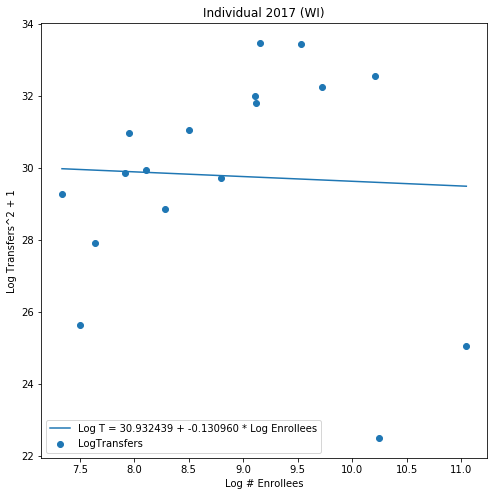

Individual 2017 (WI)
Log T = 30.932439 + -0.130960 * Log Enrollees


In [14]:
plot(state(sg_data_14, "WI"), "Small Group 2014 (WI)", False)
plot(state(sg_data_15, "WI"), "Small Group 2015 (WI)", False)
plot(state(sg_data_16, "WI"), "Small Group 2016 (WI)", False)
plot(state(sg_data_17, "WI"), "Small Group 2017 (WI)", False)

plot(state(ind_data_14, "WI"), "Individual 2014 (WI)", False)
plot(state(ind_data_15, "WI"), "Individual 2015 (WI)", False)
plot(state(ind_data_16, "WI"), "Individual 2016 (WI)", False)
plot(state(ind_data_17, "WI"), "Individual 2017 (WI)", True)

In [15]:
state(ind_data_17, "WI")["Transfers"]

566     5304975.21
568    -2256548.65
570    18178903.48
571   -11714318.79
575    -8893268.99
576      273647.15
579     2834286.36
580    -5487189.38
581      369221.66
585    10029127.59
587    18489433.27
588     1853727.76
589     1144252.18
590    -7998779.45
591       76800.23
593     3157217.18
596     3033495.32
Name: Transfers, dtype: float64

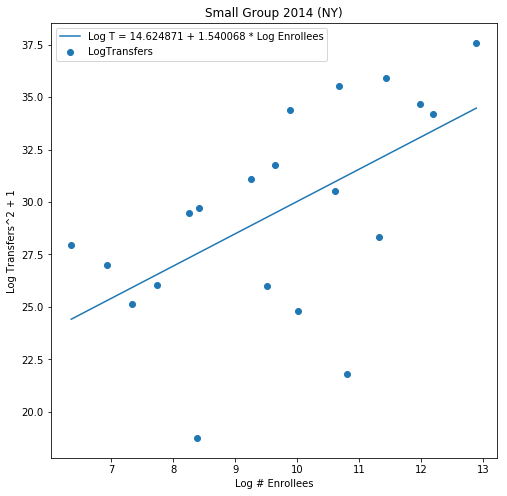

Small Group 2014 (NY)
Log T = 14.624871 + 1.540068 * Log Enrollees
Small Group 2015 (NY)
Log T = 18.267316 + 1.301260 * Log Enrollees
Small Group 2016 (NY)
Log T = 19.501643 + 1.154605 * Log Enrollees


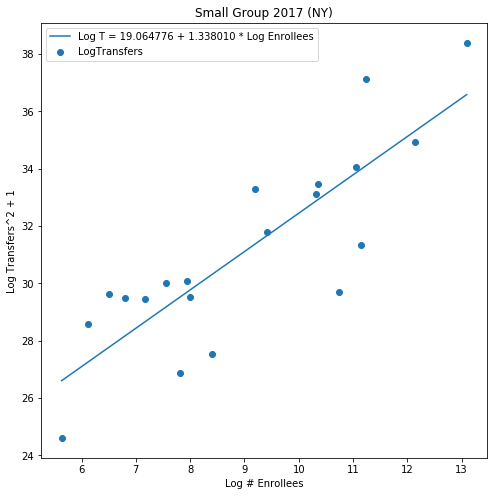

Small Group 2017 (NY)
Log T = 19.064776 + 1.338010 * Log Enrollees


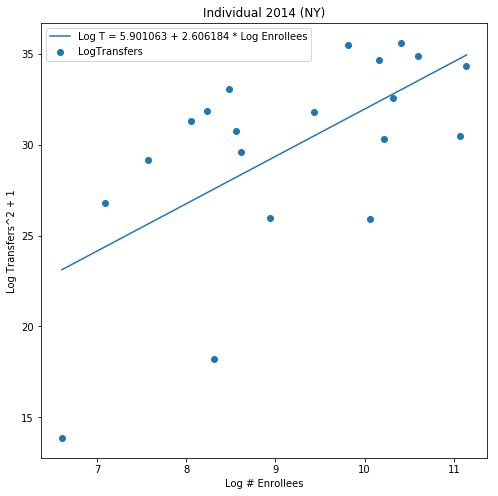

Individual 2014 (NY)
Log T = 5.901063 + 2.606184 * Log Enrollees
Individual 2015 (NY)
Log T = 15.160759 + 1.775863 * Log Enrollees
Individual 2016 (NY)
Log T = 15.910785 + 1.694897 * Log Enrollees
Individual 2017 (NY)
Log T = 17.462005 + 1.517902 * Log Enrollees


In [135]:
plot(state(sg_data_14, "NY"), "Small Group 2014 (NY)", True)
plot(state(sg_data_15, "NY"), "Small Group 2015 (NY)", False)
plot(state(sg_data_16, "NY"), "Small Group 2016 (NY)", False)
plot(state(sg_data_17, "NY"), "Small Group 2017 (NY)", True)

plot(state(ind_data_14, "NY"), "Individual 2014 (NY)", True)
plot(state(ind_data_15, "NY"), "Individual 2015 (NY)", False)
plot(state(ind_data_16, "NY"), "Individual 2016 (NY)", False)
plot(state(ind_data_17, "NY"), "Individual 2017 (NY)", False)

In [17]:
# Shaprio-Wilk test for null hypothesis that sample x1... xn
# comes form a normally distributed population

def shapir(df, label):
    a, b = stats.shapiro(df)
    print("%s,%.4f,%.4f" % (label,a,b))


In [18]:
print(",P(Transfers from normal distr),p-value")

,P(Transfers from normal distr),p-value


In [19]:
shapir(remove_outliers(sg_data_14)["TransfersPerSqrtEnrollee"], "All States, SG, 2014")
shapir(remove_outliers(sg_data_15)["TransfersPerSqrtEnrollee"], "All States, SG, 2015")
shapir(remove_outliers(sg_data_16)["TransfersPerSqrtEnrollee"], "All States, SG, 2016")
shapir(remove_outliers(sg_data_17)["TransfersPerSqrtEnrollee"], "All States, SG, 2017")

All States, SG, 2014,0.6163,0.0000
All States, SG, 2015,0.5646,0.0000
All States, SG, 2016,0.7191,0.0000
All States, SG, 2017,0.7558,0.0000


In [20]:
shapir(state(sg_data_14, "CA")["TransfersPerSqrtEnrollee"], "CA only, SG, 2014")
shapir(state(sg_data_15, "CA")["TransfersPerSqrtEnrollee"], "CA only, SG, 2015")
shapir(state(sg_data_16, "CA")["TransfersPerSqrtEnrollee"], "CA only, SG, 2016")
shapir(state(sg_data_17, "CA")["TransfersPerSqrtEnrollee"], "CA only, SG, 2017")

CA only, SG, 2014,0.8497,0.0220
CA only, SG, 2015,0.9567,0.6017
CA only, SG, 2016,0.9375,0.3198
CA only, SG, 2017,0.9493,0.5138


In [21]:
shapir(state(sg_data_14, "WI")["TransfersPerSqrtEnrollee"], "WI only, SG, 2014")
shapir(state(sg_data_15, "WI")["TransfersPerSqrtEnrollee"], "WI only, SG, 2015")
shapir(state(sg_data_16, "WI")["TransfersPerSqrtEnrollee"], "WI only, SG, 2016")
shapir(state(sg_data_17, "WI")["TransfersPerSqrtEnrollee"], "WI only, SG, 2017")

WI only, SG, 2014,0.7147,0.0000
WI only, SG, 2015,0.8352,0.0004
WI only, SG, 2016,0.9627,0.4484
WI only, SG, 2017,0.9719,0.7344


In [22]:
shapir(state(sg_data_14, "NY")["TransfersPerSqrtEnrollee"], "NY only, SG, 2014")
shapir(state(sg_data_15, "NY")["TransfersPerSqrtEnrollee"], "NY only, SG, 2015")
shapir(state(sg_data_16, "NY")["TransfersPerSqrtEnrollee"], "NY only, SG, 2016")
shapir(state(sg_data_17, "NY")["TransfersPerSqrtEnrollee"], "NY only, SG, 2017")

NY only, SG, 2014,0.8868,0.0235
NY only, SG, 2015,0.7842,0.0005
NY only, SG, 2016,0.8418,0.0050
NY only, SG, 2017,0.8103,0.0012


In [23]:
NY2014 = state(sg_data_14, "NY")[["HIOS INPUTTED INSURANCE COMPANY NAME", "TransfersPerSqrtEnrollee", "Transfers", "Enrollees", "MM", "TransfersPMM"]]

In [177]:
def erfinv2(sample_size):# sig):
    # erf inverse 0.5 * p/k where p=0.05
    print("Sample size %d" % (sample_size))
    return special.erfinv(1-0.5*0.05/sample_size) * np.sqrt(2)# * sig

def num_pass(df, a):
    sample_size = df.shape[0]
    count = 0
    delta = erfinv2(sample_size)
    print("Delta_0 % .3f" % (delta))
    es1 = max(abs(df["TransfersPerSqrtEnrollee"])) / delta
    print("Comparison es_0 = %.3f" % (es1))
    print("Comparison es_0*%.2f = %.3f" % (a, a*es1))
    
    for index, row in df.iterrows():
        t = row["Transfers"]
        n = row["Enrollees"]
        if abs(row["TransfersPerSqrtEnrollee"]) < a*es1:
            count += 1
            print("T/sqrt(N)=%.3f \t <a*es_0 Satisfied" % (row["TransfersPerSqrtEnrollee"]))
        else:
            print("T/sqrt(N)=%.3f \t <a*es_0 NOT Satisfied \t Distance |T/sqrt(N)|-a*es_0 %.1f " % (row["TransfersPerSqrtEnrollee"], abs(row["TransfersPerSqrtEnrollee"]) - a*es1))
    return count
    
def binom(k, n, p):
    return stats.binom.cdf(k, n, p)

In [178]:
def run_stat_test(data, label, a):
    print(label)
    p01 = special.erf(a/np.sqrt(2))
    print("P01 = %.3f" % (p01))
    successes = num_pass(data, a)
    print("Number of successes: %d" % (successes))
    print("P value = %.3f" % (1- binom(successes, data.shape[0], p01)))

In [179]:
run_stat_test(state(sg_data_14, "NY"), "NY SG 2014", 0.1)

NY SG 2014
P01 = 0.080
Sample size 20
Delta_0  3.227
Comparison es_0 = 77712.505
Comparison es_0*0.10 = 7771.250
T/sqrt(N)=-3771.364 	 <a*es_0 Satisfied
T/sqrt(N)=-204546.131 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 196774.9 
T/sqrt(N)=55797.937 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 48026.7 
T/sqrt(N)=-4967.824 	 <a*es_0 Satisfied
T/sqrt(N)=-40522.228 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 32751.0 
T/sqrt(N)=-64143.035 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 56371.8 
T/sqrt(N)=59742.849 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 51971.6 
T/sqrt(N)=-250795.228 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 243024.0 
T/sqrt(N)=178.576 	 <a*es_0 Satisfied
T/sqrt(N)=-210325.111 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 202553.9 
T/sqrt(N)=-246.943 	 <a*es_0 Satisfied
T/sqrt(N)=7350.314 	 <a*es_0 Satisfied
T/sqrt(N)=20991.104 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 13219.9 
T/sqrt(N)=-48788

In [180]:
run_stat_test(state(sg_data_15, "NY"), "NY SG 2015", 0.1)

NY SG 2015
P01 = 0.080
Sample size 20
Delta_0  3.227
Comparison es_0 = 200013.088
Comparison es_0*0.10 = 20001.309
T/sqrt(N)=-70944.878 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 50943.6 
T/sqrt(N)=-271979.813 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 251978.5 
T/sqrt(N)=37827.748 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 17826.4 
T/sqrt(N)=-107369.002 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 87367.7 
T/sqrt(N)=-302.731 	 <a*es_0 Satisfied
T/sqrt(N)=-35391.486 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 15390.2 
T/sqrt(N)=-25295.228 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 5293.9 
T/sqrt(N)=-32083.739 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 12082.4 
T/sqrt(N)=-4159.256 	 <a*es_0 Satisfied
T/sqrt(N)=-44073.384 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 24072.1 
T/sqrt(N)=-19212.035 	 <a*es_0 Satisfied
T/sqrt(N)=-645485.923 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 625484.6 
T/sqrt

In [181]:
run_stat_test(state(sg_data_16, "NY"), "NY SG 2016", 0.1)
run_stat_test(state(sg_data_16, "NY"), "NY SG 2016", 0.2)

NY SG 2016
P01 = 0.080
Sample size 19
Delta_0  3.213
Comparison es_0 = 140440.381
Comparison es_0*0.10 = 14044.038
T/sqrt(N)=-133158.128 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 119114.1 
T/sqrt(N)=-451166.626 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 437122.6 
T/sqrt(N)=-219950.411 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 205906.4 
T/sqrt(N)=133.265 	 <a*es_0 Satisfied
T/sqrt(N)=-95052.014 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 81008.0 
T/sqrt(N)=-34081.709 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 20037.7 
T/sqrt(N)=-276119.960 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 262075.9 
T/sqrt(N)=-36855.961 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 22811.9 
T/sqrt(N)=29029.544 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 14985.5 
T/sqrt(N)=-63407.545 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 49363.5 
T/sqrt(N)=9116.179 	 <a*es_0 Satisfied
T/sqrt(N)=-35254.535 	 <a*es_0 NOT Satisfied 

In [182]:
run_stat_test(state(sg_data_17, "NY"), "NY SG 2017", .10)

NY SG 2017
P01 = 0.080
Sample size 20
Delta_0  3.227
Comparison es_0 = 130372.840
Comparison es_0*0.10 = 13037.284
T/sqrt(N)=-83936.051 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 70898.8 
T/sqrt(N)=-99134.340 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 86097.1 
T/sqrt(N)=12954.997 	 <a*es_0 Satisfied
T/sqrt(N)=-89550.599 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 76513.3 
T/sqrt(N)=-64714.498 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 51677.2 
T/sqrt(N)=-72822.915 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 59785.6 
T/sqrt(N)=-13830.985 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 793.7 
T/sqrt(N)=-47259.284 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 34222.0 
T/sqrt(N)=-75476.710 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 62439.4 
T/sqrt(N)=-13194.282 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 157.0 
T/sqrt(N)=-68637.891 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 55600.6 
T/sqrt(N)

In [184]:
run_stat_test(state(sg_data_14, "WI"), "WI SG 2014", .10)

WI SG 2014
P01 = 0.080
Sample size 26
Delta_0  3.302
Comparison es_0 = 15422.693
Comparison es_0*0.10 = 1542.269
T/sqrt(N)=-7103.710 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 5561.4 
T/sqrt(N)=-663.593 	 <a*es_0 Satisfied
T/sqrt(N)=-746.438 	 <a*es_0 Satisfied
T/sqrt(N)=-50918.717 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 49376.4 
T/sqrt(N)=-3204.441 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 1662.2 
T/sqrt(N)=973.768 	 <a*es_0 Satisfied
T/sqrt(N)=-2765.049 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 1222.8 
T/sqrt(N)=-28225.773 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 26683.5 
T/sqrt(N)=-1488.204 	 <a*es_0 Satisfied
T/sqrt(N)=429.120 	 <a*es_0 Satisfied
T/sqrt(N)=14166.236 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 12624.0 
T/sqrt(N)=4732.016 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3189.7 
T/sqrt(N)=-1452.621 	 <a*es_0 Satisfied
T/sqrt(N)=-10454.277 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 

In [185]:
run_stat_test(state(sg_data_15, "WI"), "WI SG 2015", .10)

WI SG 2015
P01 = 0.080
Sample size 29
Delta_0  3.332
Comparison es_0 = 27208.196
Comparison es_0*0.10 = 2720.820
T/sqrt(N)=-5884.726 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3163.9 
T/sqrt(N)=-3903.234 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 1182.4 
T/sqrt(N)=-227.480 	 <a*es_0 Satisfied
T/sqrt(N)=-29168.289 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 26447.5 
T/sqrt(N)=5313.152 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 2592.3 
T/sqrt(N)=-8789.759 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 6068.9 
T/sqrt(N)=-45915.731 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 43194.9 
T/sqrt(N)=5882.472 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3161.7 
T/sqrt(N)=-12854.952 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 10134.1 
T/sqrt(N)=6057.130 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3336.3 
T/sqrt(N)=4241.400 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 1520.6 
T/sqrt(N)=5819.110 	 <a*es

In [186]:
run_stat_test(state(sg_data_16, "WI"), "WI SG 2016", .10)

WI SG 2016
P01 = 0.080
Sample size 26
Delta_0  3.302
Comparison es_0 = 20973.047
Comparison es_0*0.10 = 2097.305
T/sqrt(N)=-40539.213 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 38441.9 
T/sqrt(N)=-17556.349 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 15459.0 
T/sqrt(N)=-41023.419 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 38926.1 
T/sqrt(N)=10378.699 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 8281.4 
T/sqrt(N)=1134.061 	 <a*es_0 Satisfied
T/sqrt(N)=16353.180 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 14255.9 
T/sqrt(N)=-25255.032 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 23157.7 
T/sqrt(N)=-69243.463 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 67146.2 
T/sqrt(N)=-37.326 	 <a*es_0 Satisfied
T/sqrt(N)=13914.889 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 11817.6 
T/sqrt(N)=6096.559 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3999.3 
T/sqrt(N)=33080.017 	 <a*es_0 NOT Satisfied 	 Distance |T/sqr

In [187]:
run_stat_test(state(sg_data_17, "WI"), "WI SG 2017", .10)

WI SG 2017
P01 = 0.080
Sample size 23
Delta_0  3.267
Comparison es_0 = 21048.747
Comparison es_0*0.10 = 2104.875
T/sqrt(N)=-32394.708 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 30289.8 
T/sqrt(N)=5417.537 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3312.7 
T/sqrt(N)=15857.939 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 13753.1 
T/sqrt(N)=-23965.240 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 21860.4 
T/sqrt(N)=2336.625 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 231.8 
T/sqrt(N)=3798.517 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 1693.6 
T/sqrt(N)=-36880.071 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 34775.2 
T/sqrt(N)=-19000.413 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 16895.5 
T/sqrt(N)=-18647.812 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 16542.9 
T/sqrt(N)=-12625.120 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 10520.2 
T/sqrt(N)=-4960.918 	 <a*es_0 NOT Satisfied 	 Distance |T/

In [188]:
run_stat_test(state(sg_data_14, "CA"), "CA SG 2014", .10)

CA SG 2014
P01 = 0.080
Sample size 14
Delta_0  3.124
Comparison es_0 = 27170.892
Comparison es_0*0.10 = 2717.089
T/sqrt(N)=-84874.656 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 82157.6 
T/sqrt(N)=-5899.099 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3182.0 
T/sqrt(N)=38997.765 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 36280.7 
T/sqrt(N)=37672.299 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 34955.2 
T/sqrt(N)=-72749.665 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 70032.6 
T/sqrt(N)=29011.286 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 26294.2 
T/sqrt(N)=-4629.056 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 1912.0 
T/sqrt(N)=-8770.933 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 6053.8 
T/sqrt(N)=-7589.597 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 4872.5 
T/sqrt(N)=-6397.976 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 3680.9 
T/sqrt(N)=-9831.986 	 <a*es_0 NOT Satisfied 	 Distance |T/sq

In [189]:
run_stat_test(state(sg_data_15, "CA"), "CA SG 2015", .10)

CA SG 2015
P01 = 0.080
Sample size 16
Delta_0  3.163
Comparison es_0 = 60449.296
Comparison es_0*0.10 = 6044.930
T/sqrt(N)=-191190.121 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 185145.2 
T/sqrt(N)=26592.670 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 20547.7 
T/sqrt(N)=171224.950 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 165180.0 
T/sqrt(N)=-105630.884 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 99586.0 
T/sqrt(N)=115348.343 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 109303.4 
T/sqrt(N)=-35022.208 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 28977.3 
T/sqrt(N)=-7039.841 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 994.9 
T/sqrt(N)=23216.950 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 17172.0 
T/sqrt(N)=-60168.174 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 54123.2 
T/sqrt(N)=-8908.985 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 2864.1 
T/sqrt(N)=-24673.533 	 <a*es_0 NOT Satisfied 	 Di

In [190]:
run_stat_test(state(sg_data_16, "CA"), "CA SG 2016", .10)

CA SG 2016
P01 = 0.080
Sample size 16
Delta_0  3.163
Comparison es_0 = 107903.448
Comparison es_0*0.10 = 10790.345
T/sqrt(N)=-281547.972 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 270757.6 
T/sqrt(N)=-120000.332 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 109210.0 
T/sqrt(N)=-48525.434 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 37735.1 
T/sqrt(N)=12215.609 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 1425.3 
T/sqrt(N)=-88149.680 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 77359.3 
T/sqrt(N)=-57705.658 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 46915.3 
T/sqrt(N)=341278.965 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 330488.6 
T/sqrt(N)=90221.616 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 79431.3 
T/sqrt(N)=157665.542 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 146875.2 
T/sqrt(N)=-105532.366 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 94742.0 
T/sqrt(N)=-63259.335 	 <a*es_0 NOT Satisf

In [193]:
run_stat_test(state(sg_data_17, "CA"), "CA SG 2017", 2)

CA SG 2017
P01 = 0.954
Sample size 15
Delta_0  3.144
Comparison es_0 = 108947.075
Comparison es_0*2.00 = 217894.151
T/sqrt(N)=10708.915 	 <a*es_0 Satisfied
T/sqrt(N)=-14849.597 	 <a*es_0 Satisfied
T/sqrt(N)=325640.012 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 107745.9 
T/sqrt(N)=-342527.457 	 <a*es_0 NOT Satisfied 	 Distance |T/sqrt(N)|-a*es_0 124633.3 
T/sqrt(N)=109113.676 	 <a*es_0 Satisfied
T/sqrt(N)=-40163.170 	 <a*es_0 Satisfied
T/sqrt(N)=-135295.815 	 <a*es_0 Satisfied
T/sqrt(N)=22636.640 	 <a*es_0 Satisfied
T/sqrt(N)=-112727.188 	 <a*es_0 Satisfied
T/sqrt(N)=796.809 	 <a*es_0 Satisfied
T/sqrt(N)=-31615.485 	 <a*es_0 Satisfied
T/sqrt(N)=196646.013 	 <a*es_0 Satisfied
T/sqrt(N)=-64658.352 	 <a*es_0 Satisfied
T/sqrt(N)=8001.700 	 <a*es_0 Satisfied
T/sqrt(N)=103946.657 	 <a*es_0 Satisfied
Number of successes: 13
P value = 0.853


In [201]:
print(np.mean(state(sg_data_14, "CA")["CostsPMM"]))
print(np.mean(state(sg_data_15, "CA")["CostsPMM"]))
print(np.mean(state(sg_data_16, "CA")["CostsPMM"]))
print(np.mean(state(sg_data_17, "CA")["CostsPMM"]))

310.37140496645634
316.89499601330317
351.7297958148017
398.7784293663904


In [202]:
print(np.mean(state(sg_data_14, "NY")["CostsPMM"]))
print(np.mean(state(sg_data_15, "NY")["CostsPMM"]))
print(np.mean(state(sg_data_16, "NY")["CostsPMM"]))
print(np.mean(state(sg_data_17, "NY")["CostsPMM"]))

337.4649435797306
343.66981918083303
360.9995994568882
359.03065361603274


In [203]:
print(np.mean(state(sg_data_14, "WI")["CostsPMM"]))
print(np.mean(state(sg_data_15, "WI")["CostsPMM"]))
print(np.mean(state(sg_data_16, "WI")["CostsPMM"]))
print(np.mean(state(sg_data_17, "WI")["CostsPMM"]))

337.1899385612042
359.7252586639627
376.3166138137452
369.0653951541943
